

Install dependencies




In [1]:
# !pip install tensorflow-gpu==2.2 keras simpleitk matplotlib scikit-image

In [2]:
# pip uninstall tensorflow-gpu tensorflow keras

In [3]:
# !pip install git+https://github.com/JihongJu/keras-resnet3d.git

Import Packages

In [4]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   #if like me you do not have a lot of memory in your GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "" #then these two lines force keras to use your CPU
# import keras
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
# from keras.layers import Dense, Dropout, Activation, Flatten, Lambda
# from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization as BN
# from keras.layers import GaussianNoise as GN
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, MaxPool3D, GlobalAveragePooling3D, Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.utils import Sequence
# from tensorflow.python.keras.utils import data_utils
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
# from skimage.transform import resize
# from sklearn import preprocessing

from glob import glob

import SimpleITK as sitk
# import nibabel as nib

**Load and prepare data**

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

# project_dir = "drive/MyDrive/Colab Notebooks/TFM/DATA/"

project_dir = "/home/pmeslaf/DATA/"

In [6]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
# config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
# config = tf.config.experimental.set_memory_growth(physical_devices[1], True)

In [7]:
batch_size = 1
epochs = 100
# frozen_epochs = 100
num_classes = 3
images_shape = (150,150,120)
n_channels = 1

Custom Image Generator

In [8]:
from data_generator import DataGenerator

**Prepare data**

In [9]:
training_generator = DataGenerator(data_path=project_dir + '/Train/',
                                   dim=images_shape,
                                   batch_size = batch_size,
                                   n_channels = n_channels,
                                   num_classes=num_classes,
                                   shuffle=True,
                                   rotation=60)
# valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(data_path=project_dir + '/Test/',
                                   dim=images_shape,
                                   batch_size = batch_size,
                                   n_channels = n_channels,
                                   num_classes=num_classes,
                                   shuffle=False)


1434 image(s) found in /home/pmeslaf/DATA//Train/
475 image(s) found in /home/pmeslaf/DATA//Test/


len  1434
<class 'int'>
len  1434
(256, 256, 170)
(150, 191, 117)
(243, 237, 117, 1)


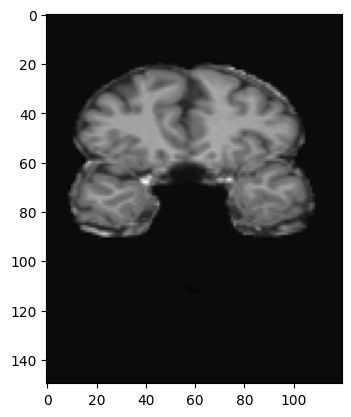

<class 'data_generator.DataGenerator'>


In [13]:
print('len ', str(training_generator.__len__()))
print(type(training_generator.__len__()))
print('len ', str(len(training_generator)))
# X, y = training_generator.__getitem__(1)
X, y = training_generator[1]
# print(X[0,0,:,:,0])
plt.imshow(X[0,100,:,:, 0], cmap='gray' )
plt.show()

print(type(training_generator))


**MODEL**

In [ ]:
from tensorflow.keras.models import Model
sample_shape=(192,192,160,1)
# Create the model
# model = Sequential()
# model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization(center=True, scale=True))
# model.add(Dropout(0.5))
# # model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
# # model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# # model.add(BatchNormalization(center=True, scale=True))
# # model.add(Dropout(0.5))
# model.add(Flatten())
# model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
# model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
# model.add(Dense(10, activation='softmax'))

# model.summary()


# from resnet3d import Resnet3DBuilder
# base_model = Resnet3DBuilder.build_resnet_18(
#     input_shape=sample_shape,
#     num_outputs=num_classes,
#     reg_factor=0.04
# )

# # add the final layers and compile
# fc_layer = tf.keras.layers.Dense(512, activation='relu')(base_model.layers[-2].output)
# fc_layer = tf.keras.layers.Dropout(0.8)(fc_layer)
# output_layer = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(fc_layer)
# model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)
# optimizer = tf.keras.optimizers.Adam(lr=0.00001)
# model.compile(optimizer=optimizer, 
#               loss='categorical_crossentropy', 
#               metrics=['acc'])

# # train the model
# model.fit(x=image_tensor, y=label_tensor, epochs=50, 
#           steps_per_epoch=STEPS_PER_EPOCH, 
#           validation_data=val_tensor, 
#           validation_steps=VALIDATION_STEPS)


def get_model(width=192, height=192, depth=160):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling3D()(x)
    x = Dense(units=512, activation="relu")(x)
    x = Dropout(0.3)(x)

    outputs = Dense(units=num_classes, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# # Build model.
# model = get_model(width=192, height=192, depth=160)
# model.summary()

In [ ]:
## DEF A BLOCK CONV + BN + GN + CONV + BN + GN + MAXPOOL 
def CBGN(model,filters,lname,ishape=0):
  if (ishape!=0):
    model.add(Conv3D(filters=filters, kernel_size=3, activation="relu",
                 input_shape=ishape))
  else:
    model.add(Conv3D(filters=filters, kernel_size=3, activation="relu"))

  model.add(MaxPool3D(pool_size=2,name=lname))
  
  return model


model = Sequential()

model=CBGN(model,32,'conv_model_1',(images_shape[0], images_shape[1], images_shape[2], 1))
model=CBGN(model,64,'conv_model_2')
model=CBGN(model,128,'conv_modeL_3')
model=CBGN(model,256,'conv_modeL_4')
# model=CBGN(model,512,'conv_model_5')

# model.add(Flatten())
model.add(GlobalAveragePooling3D())
model.add(Dense(units=512, activation="relu"))
model.add(BN())
# model.add(GN(0.3))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
# model.add(Activation('sigmoid'))

model.summary()

In [ ]:
# plot_model(model, 
#            show_shapes = True,
#            show_dtype=False,
#            show_layer_names = True, 
#            rankdir = 'TB', 
#            expand_nested = False, 
#            dpi = 70)

In [ ]:
opt = Adam(1, decay=1e-6)

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
# Fit data to model
history = model.fit(x=training_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data = test_generator)